# First Shot on Subtask A: Validation
Updated on August 1, 2021.

#### Project Information:
* Summer Project: Commonsense Validation and Explanation in Natural Language Processing<br>
* Objective Task: SemEval 2020 Task 4 - Commonsense Validation and Explanation (ComVE)<br>
* Supervisor: Dr Mark Lee<br>
* Student: Letian Li (2214560)
 
#### Task Description:
The subtask A is a validation task. The purpose is to determine which of two similar natural language statements is against common sense.

*Example:*  
> Task: Which statement of the two is against common sense?  
> Statement1: He put a turkey into the fridge.  
> Statement2: He put an elephant into the fridge. 

#### Solution:
This program will follow the steps:
1. General Preparation  
2. Data processing 
3. Load model and optimizer  
4. Training 
5. Test 

<!-- #### Task Description:
The subtask A is a validation task. The purpose is going to tell which of two similar natural language statements is against common sense.

*Example:* 
        
    Task: Which statement of the two is against common sense?
    Statement1: He put a turkey into the fridge.  
    Statement2: He put an elephant into the fridge.    -->

## 1. General Preparation

Import some common libraries.

In [1]:
from tqdm import tqdm
import time

Use GPU Facilities.

In [2]:
import torch
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

## 2. Data processing

### 2.1 Read data from csv

Build a common function to get texts and labels from csv file.

In [3]:
import pandas as pd
def get_info_from_csv(texts_path, labels_path):
    texts = pd.read_csv(texts_path, header=0, names=['ID', 'Statement 0', 'Statement 1'])
    labels = pd.read_csv(labels_path, header=None, names=['ID', 'Answer'])
    return texts, labels

Read texts and labels from csv file.

In [4]:
train_texts, train_labels = get_info_from_csv(
    'ALL data/Training Data/subtaskA_data_all.csv',
    'ALL data/Training Data/subtaskA_answers_all.csv'
)

val_texts, val_labels = get_info_from_csv(
    'ALL data/Dev Data/subtaskA_dev_data.csv',
    'ALL data/Dev Data/subtaskA_gold_answers.csv'
)

test_texts, test_labels = get_info_from_csv(
    'ALL data/Test Data/subtaskA_test_data.csv',
    'ALL data/Test Data/subtaskA_gold_answers.csv'
)

Let's have a look at the training data.

In [5]:
train_data = pd.merge(train_texts, train_labels, how='left', on='ID')
train_data.head()

,ID,Statement 0,Statement 1,Answer
0,0,He poured orange juice on his cereal.,He poured milk on his cereal.,0
1,1,He drinks apple.,He drinks milk.,0
2,2,Jeff ran a mile today,"Jeff ran 100,000 miles today",1
3,3,A mosquito stings me,I sting a mosquito,1
4,4,A niece is a person.,A giraffe is a person.,1


### 2.2 Tokenization

In [6]:
from transformers import DistilBertTokenizerFast

# Get tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenization for texts
train_encodings = tokenizer(list(train_texts["Statement 0"]), list(train_texts["Statement 1"]), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts["Statement 0"]), list(val_texts["Statement 1"]), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts["Statement 0"]), list(test_texts["Statement 1"]), truncation=True, padding=True)

### 2.3 Turn data into a Dataset object

Define a Dataset class.

In [7]:
class ComVEDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

Turn encodings and labels into a Dataset object.

In [8]:
# Adjust the labels
train_labels = train_labels['Answer']
val_labels = val_labels['Answer']
test_labels = test_labels['Answer']

# Turn encodings and labels into a Dataset object
train_dataset = ComVEDataset(train_encodings, train_labels)
val_dataset = ComVEDataset(val_encodings, val_labels)
test_dataset = ComVEDataset(test_encodings, test_labels)

## 3. Load model and optimizer

In [9]:
from transformers import DistilBertForSequenceClassification, AdamW

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(device)

optim = AdamW(model.parameters(), lr=5e-5)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

## 4. Training

Prepare some utility functions.

In [10]:
# Prediction function
def predict(outputs):
    prediction = outputs["logits"].softmax(dim=1).argmax(dim=1, keepdim=True)
    return prediction

Training procedure

In [11]:
# Training
from torch.utils.data import DataLoader

# Set the number of epochs
epochs = 10

# Get training data by DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Start training
model.train()

train_loss = list()
for epoch in range(epochs):
    print('Epoch %s/%s' % (epoch + 1, epochs))
    time.sleep(0.3)
    
    correct = 0
    count = 0
    epoch_loss = list()
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()
        
        # make a prediction
        prediction = predict(outputs)

        # count accuracy
        correct += prediction.eq(labels.view_as(prediction)).sum().item()
        count += len(labels)

        # show progress along with metrics
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(correct * 1.0 / count)
        })
        
        # record the loss
        epoch_loss.append(loss.item())
        
    pbar.close()
    train_loss += epoch_loss

Epoch 1/10


100%|██████████| 625/625 [00:28<00:00, 22.30it/s, loss=0.427, accuracy=0.542]


Epoch 2/10


100%|██████████| 625/625 [00:28<00:00, 22.04it/s, loss=0.362, accuracy=0.765]


Epoch 3/10


100%|██████████| 625/625 [00:27<00:00, 22.79it/s, loss=0.508, accuracy=0.884]


Epoch 4/10


100%|██████████| 625/625 [00:27<00:00, 22.65it/s, loss=0.078, accuracy=0.944]


Epoch 5/10


100%|██████████| 625/625 [00:25<00:00, 24.59it/s, loss=0.033, accuracy=0.966]


Epoch 6/10


100%|██████████| 625/625 [00:25<00:00, 24.99it/s, loss=0.184, accuracy=0.981]


Epoch 7/10


100%|██████████| 625/625 [00:25<00:00, 24.51it/s, loss=0.000, accuracy=0.987]


Epoch 8/10


100%|██████████| 625/625 [00:25<00:00, 24.15it/s, loss=0.066, accuracy=0.989]


Epoch 9/10


100%|██████████| 625/625 [00:27<00:00, 22.51it/s, loss=0.001, accuracy=0.988]


Epoch 10/10


100%|██████████| 625/625 [00:27<00:00, 22.48it/s, loss=0.009, accuracy=0.989]


Visualise training loss.

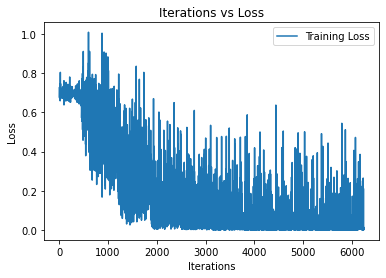

In [12]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")  
plt.legend()
plt.show()

## 5. Test

Test procedure

In [13]:
# Testing
from torch.utils.data import DataLoader

# Get test data by DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Start testing
model.eval()

with torch.no_grad():
    
    correct = 0
    count = 0
    record = list()
    
    pbar = tqdm(test_loader)
    for batch in pbar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        
        # make a prediction
        prediction = predict(outputs)

        # count accuracy
        correct += prediction.eq(labels.view_as(prediction)).sum().item()
        count += len(labels)

        # show progress along with metrics
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(correct * 1.0 / count)
        })
    
        # record the results
        record.append((int(labels),int(prediction)))
        

    pbar.close()

100%|██████████| 1000/1000 [00:07<00:00, 134.24it/s, loss=0.000, accuracy=0.786]


Check the result.

In [14]:
# Show test result
for idx,item in enumerate(record):
    print("Statements %s:" % idx)
    print("Ground Truth:",item[0],"vs. Model Prediction:",item[1])

Statements 0:
Ground Truth: 0 vs. Model Prediction: 0
Statements 1:
Ground Truth: 0 vs. Model Prediction: 0
Statements 2:
Ground Truth: 0 vs. Model Prediction: 0
Statements 3:
Ground Truth: 0 vs. Model Prediction: 1
Statements 4:
Ground Truth: 1 vs. Model Prediction: 1
Statements 5:
Ground Truth: 0 vs. Model Prediction: 0
Statements 6:
Ground Truth: 1 vs. Model Prediction: 1
Statements 7:
Ground Truth: 0 vs. Model Prediction: 0
Statements 8:
Ground Truth: 0 vs. Model Prediction: 1
Statements 9:
Ground Truth: 1 vs. Model Prediction: 1
Statements 10:
Ground Truth: 0 vs. Model Prediction: 0
Statements 11:
Ground Truth: 0 vs. Model Prediction: 0
Statements 12:
Ground Truth: 0 vs. Model Prediction: 0
Statements 13:
Ground Truth: 1 vs. Model Prediction: 1
Statements 14:
Ground Truth: 1 vs. Model Prediction: 1
Statements 15:
Ground Truth: 1 vs. Model Prediction: 1
Statements 16:
Ground Truth: 0 vs. Model Prediction: 0
Statements 17:
Ground Truth: 0 vs. Model Prediction: 0
Statements 18:
Groun

Ground Truth: 1 vs. Model Prediction: 1
Statements 511:
Ground Truth: 1 vs. Model Prediction: 1
Statements 512:
Ground Truth: 1 vs. Model Prediction: 1
Statements 513:
Ground Truth: 1 vs. Model Prediction: 1
Statements 514:
Ground Truth: 0 vs. Model Prediction: 1
Statements 515:
Ground Truth: 1 vs. Model Prediction: 1
Statements 516:
Ground Truth: 0 vs. Model Prediction: 0
Statements 517:
Ground Truth: 1 vs. Model Prediction: 1
Statements 518:
Ground Truth: 0 vs. Model Prediction: 0
Statements 519:
Ground Truth: 1 vs. Model Prediction: 0
Statements 520:
Ground Truth: 1 vs. Model Prediction: 0
Statements 521:
Ground Truth: 1 vs. Model Prediction: 1
Statements 522:
Ground Truth: 0 vs. Model Prediction: 1
Statements 523:
Ground Truth: 0 vs. Model Prediction: 0
Statements 524:
Ground Truth: 1 vs. Model Prediction: 1
Statements 525:
Ground Truth: 0 vs. Model Prediction: 1
Statements 526:
Ground Truth: 1 vs. Model Prediction: 1
Statements 527:
Ground Truth: 0 vs. Model Prediction: 0
Statemen

In [15]:
# Manual Test
check_id = 999

test_data = list(test_loader)
check_target = test_data[check_id]
# print("check_target:",check_target)

input_ids = check_target['input_ids'].to(device)
attention_mask = check_target['attention_mask'].to(device)
labels = check_target['labels']
# print("input_ids:",input_ids)

statements_str = tokenizer.decode(input_ids[0],skip_special_tokens=False)
statements = statements_str.split("[CLS]")[1].split("[SEP]")
print("Task: Which statement of the two is against common sense?")
print("Statement 0:",statements[0])
print("Statement 1:",statements[1])
print()

outputs = model(input_ids, attention_mask=attention_mask)
prediction = predict(outputs)
print("Model Prediction:",int(prediction))
print("Ground Truth:",int(labels))

Task: Which statement of the two is against common sense?
Statement 0:  my friend runs for 2 inches every day. 
Statement 1:  my friend runs for 2 miles every day. 

Model Prediction: 0
Ground Truth: 0
